In [1]:
import sys
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from starcat import BuildConsensusReference, starCAT


Provides example code for building a new starCAT reference based on cNMF results from multiple datasets.

This tutorial does not run cNMF itself but uses results that are already saved. For more information about running cNMF, see the [build_reference_vignette.ipynb](./build_reference_vignette.ipynb) example and refer to the [cNMF github page](https://github.com/dylkot/cNMF/tree/master).

# Download the cNMF results and example query data

In [3]:
! wget https://zenodo.org/records/13368101/files/Example_refbuilder.tar.gz

--2024-08-23 17:20:16--  https://zenodo.org/records/13368101/files/Example_refbuilder.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24294951 (23M) [application/octet-stream]
Saving to: ‘Example_refbuilder.tar.gz’

Example_refbuilder. 100%[===================>]  23.17M  2.63MB/s    in 9.6s    

2024-08-23 17:20:26 (2.41 MB/s) - ‘Example_refbuilder.tar.gz’ saved [24294951/24294951]



In [4]:
! tar -zxvf Example_refbuilder.tar.gz   

x Example_refbuilder/
x Example_refbuilder/UKCOVID.20231005.Iter200/
x Example_refbuilder/UKCOVID.20231005.Iter200/cnmf_tmp/
x Example_refbuilder/UKCOVID.20231005.Iter200/cnmf_tmp/UKCOVID.20231005.Iter200.tpm_stats.df.npz
x Example_refbuilder/UKCOVID.20231005.Iter200/UKCOVID.20231005.Iter200.overdispersed_genes.txt
x Example_refbuilder/UKCOVID.20231005.Iter200/UKCOVID.20231005.Iter200.gene_spectra_tpm.k_44.dt_0_2.txt
x Example_refbuilder/UKCOVID.20231005.Iter200/UKCOVID.20231005.Iter200.gene_spectra_score.k_44.dt_0_2.txt
x Example_refbuilder/HIVVaccine.20230907.Iter200/
x Example_refbuilder/HIVVaccine.20230907.Iter200/cnmf_tmp/
x Example_refbuilder/HIVVaccine.20230907.Iter200/cnmf_tmp/HIVVaccine.20230907.Iter200.tpm_stats.df.npz
x Example_refbuilder/HIVVaccine.20230907.Iter200/HIVVaccine.20230907.Iter200.overdispersed_genes.txt
x Example_refbuilder/HIVVaccine.20230907.Iter200/HIVVaccine.20230907.Iter200.gene_spectra_tpm.k_31.dt_0_15.txt
x Example_refbuilder/HIVVaccine.20230907.Iter200/

In [5]:
! rm Example_refbuilder.tar.gz   

In [6]:
! ls -lah Example_refbuilder

total 43432
drwxr-xr-x@ 6 dkotliar  staff   192B Jul 23 18:36 .
drwxr-xr-x@ 8 dkotliar  staff   256B Aug 23 17:20 ..
drwxr-x---@ 6 dkotliar  staff   192B Jul 23 20:12 COMBAT.20230927.Iter200
drwxr-x---@ 6 dkotliar  staff   192B Jul 23 20:12 HIVVaccine.20230907.Iter200
drwxr-x---@ 6 dkotliar  staff   192B Jul 23 20:12 UKCOVID.20231005.Iter200
-rw-r--r--@ 1 dkotliar  staff    21M Jul 23 20:22 example_memoryT_query.h5ad


# Run the code to merge the cluster the spectra from the multiple cNMF runs into consensus gene expression programs

In [7]:
cnmf_paths = ['Example_refbuilder/COMBAT.20230927.Iter200/',
              'Example_refbuilder/HIVVaccine.20230907.Iter200',
              'Example_refbuilder/UKCOVID.20231005.Iter200']
Ks = [35, 31, 44]
dts = [0.15, 0.15, 0.2]
outdir = './Example_refbuilder'
prefix = 'starcat_ref'

In [8]:
refbuilder = BuildConsensusReference(cnmf_paths, ks=Ks, density_thresholds=dts,
                                    output_dir=outdir, prefix=prefix)

In [9]:
clus_df, spectra_tpm_grouped, spectra_scores_grouped, hvgs_union, top_genes = refbuilder.cluster_cnmf_results()

# Look at the results

In [10]:
! ls Example_refbuilder

COMBAT.20230927.Iter200
HIVVaccine.20230907.Iter200
UKCOVID.20231005.Iter200
example_memoryT_query.h5ad
starcat_refstarcat_consensus_clustering.filtered.txt
starcat_refstarcat_consensus_clustering.txt
starcat_refstarcat_consensus_spectra_normalized.filtered.txt
starcat_refstarcat_consensus_spectra_normalized.txt
starcat_refstarcat_consensus_spectra_normalized_allgenes.filtered.txt
starcat_refstarcat_consensus_spectra_normalized_allgenes.txt
starcat_refstarcat_consensus_spectra_score.filtered.txt
starcat_refstarcat_consensus_spectra_score.txt
starcat_refstarcat_overdispersed_genes_union.txt


Output files have been saved in the Example_Refbuilder directory. The main one that is the input to starCAT is:

- ```starcat_refstarcat_consensus_spectra_normalized.filtered.txt``` - average cGEP spectra in variance normalized units subset to high variance genes. This excludes singletons. This is the default spectra we would use for starCAT.

If you don't want to exclude singletons, you can use the following instead:

- ```starcat_refstarcat_consensus_spectra_normalized.txt```

Other useful output files are:
- ```starcat_refstarcat_consensus_spectra_score.filtered.txt``` - average of spectra scores for non-singleton cGEPs. Can be used to identify cGEP marker genes
- ```starcat_refstarcat_consensus_clustering.filtered.txt``` - table showing which programs from each cNMF run clustered together and were merged
- ```starcat_refstarcat_overdispersed_genes_union.txt``` - list of high variance genes from the union of the reference datasets
- ```starcat_refstarcat_consensus_spectra_normalized_allgenes.filtered.txt``` - same as the average cGEP spectra above but including all genes and not just high variance ones

We can look at the unfiltered ```starcat_refstarcat_consensus_clustering.txt``` results below which is stored in the clus_df variable:

In [11]:
clus_df

,COMBAT.20230927.Iter200,HIVVaccine.20230907.Iter200,UKCOVID.20231005.Iter200
cGEP1,COMBAT.20230927.Iter200:23,NaN,UKCOVID.20231005.Iter200:30
cGEP2,COMBAT.20230927.Iter200:10,HIVVaccine.20230907.Iter200:10,UKCOVID.20231005.Iter200:15
cGEP3,COMBAT.20230927.Iter200:15,HIVVaccine.20230907.Iter200:24,UKCOVID.20231005.Iter200:17
cGEP4,COMBAT.20230927.Iter200:25,HIVVaccine.20230907.Iter200:25,UKCOVID.20231005.Iter200:27
cGEP5,COMBAT.20230927.Iter200:29,HIVVaccine.20230907.Iter200:30,UKCOVID.20231005.Iter200:35
cGEP6,COMBAT.20230927.Iter200:6,HIVVaccine.20230907.Iter200:9,UKCOVID.20231005.Iter200:3
cGEP7,COMBAT.20230927.Iter200:13,HIVVaccine.20230907.Iter200:21,UKCOVID.20231005.Iter200:24
cGEP8,COMBAT.20230927.Iter200:1,HIVVaccine.20230907.Iter200:3,UKCOVID.20231005.Iter200:2
cGEP9,COMBAT.20230927.Iter200:21,HIVVaccine.20230907.Iter200:16,UKCOVID.20231005.Iter200:26
cGEP10,COMBAT.20230927.Iter200:33,HIVVaccine.20230907.Iter200:31,UKCOVID.20231005.Iter200:40


# Look at top genes of merged GEPs 

To help with interpretation of the top genes associated with each cGEP and the genes that were merged together, we output the ```top_genes``` dict variable

In [12]:
top_genes['cGEP1'].head(10)

,COMBAT.20230927.Iter200,UKCOVID.20231005.Iter200,cGEP
1,AB_HLA-DR,HLA-DRA,HLA-DRA
2,HLA-DRA,HLA-DRB1,HLA-DRB1
3,HLA-DRB5,CD74,CD74
4,CD74,HLA-DRB5,HLA-DRB5
5,HLA-DRB1,HLA-DQB1,HLA-DQB1
6,HLA-DQA1,HLA-DQA1,HLA-DQA1
7,HLA-DPA1,HLA-DPA1,HLA-DPA1
8,HLA-DQB1,HLA-DMA,HLA-DMA
9,HLA-DMA,HLA-DPB1,HLA-DPB1
10,HLA-DPB1,AB_HLA-DR,HLA-DQA2


In [13]:
top_genes['cGEP2'].head(10)

,COMBAT.20230927.Iter200,HIVVaccine.20230907.Iter200,UKCOVID.20231005.Iter200,cGEP
1,MT-CYB,MT-ATP6,MT-CO2,MT-CO2
2,MT-ATP6,MT-CYB,MT-CYB,MT-CYB
3,MT-CO3,MT-CO2,MT-CO3,MT-ATP6
4,MT-ND4L,MT-ND4,MT-ND4,MT-CO3
5,MT-CO2,MT-CO3,MT-ATP6,MT-ND4
6,MT-ND5,MT-ND3,MT-CO1,MT-ND3
7,MT-ATP8,MT-ND2,MT-ND3,MT-ND5
8,MT-CO1,MT-ND1,MT-ND4L,MT-CO1
9,MT-ND3,MT-ND5,MT-ND5,MT-ND2
10,MT-ND4,MT-CO1,MT-ND1,MT-ND1


In [14]:
top_genes['cGEP3'].head(10)

,COMBAT.20230927.Iter200,HIVVaccine.20230907.Iter200,UKCOVID.20231005.Iter200,cGEP
1,MX1,ISG15,ISG15,ISG15
2,ISG15,MX1,MX1,MX1
3,IFIT3,IFI6,IFI6,IFI6
4,IFIT1,IFI44L,IFIT3,IFIT3
5,IFI6,IFIT3,OAS1,IFI44L
6,OAS1,IFIT1,IFIT1,IFIT1
7,RSAD2,XAF1,RSAD2,OAS1
8,IFI44L,RSAD2,IFI44L,RSAD2
9,LY6E,EIF2AK2,IRF7,XAF1
10,IFITM1,STAT1,CMPK2,STAT1


In [15]:
top_genes['cGEP4'].head(10)

,COMBAT.20230927.Iter200,HIVVaccine.20230907.Iter200,UKCOVID.20231005.Iter200,cGEP
1,TRDV2,TRDC,TRDV2,TRDV2
2,TRGV9,TRDV2,TRGV9,TRDC
3,AB_TCR-Vd2,TRGC1,TRDC,TRGV9
4,TRDC,AB_TCR-Vd2,AB_TCR-Vd2,KLRC1
5,AB_CD94,KLRC1,KLRC1,TRGC1
6,KLRC1,AB_CD3-1,TRGC1,ZBTB16
7,AB_TCR-V-9,TRGV9,AB_CD94,KLRD1
8,TRGC1,AB_TCR-V-9,ZBTB16,KLRG1
9,AB_CD3-1,AB_CD3-2,AB_TCR-V-9,IL18RAP
10,AB_KLRG1_MAFA,AB_CD226-1,KLRB1,HOPX


In [16]:
top_genes['cGEP7'].head(10)

,COMBAT.20230927.Iter200,HIVVaccine.20230907.Iter200,UKCOVID.20231005.Iter200,cGEP
1,FOXP3,FOXP3,FOXP3,FOXP3
2,AB_CD25,AB_CD25,RTKN2,RTKN2
3,AB_CD39,RTKN2,IL2RA,IL2RA
4,RTKN2,IL2RA,FANK1,FANK1
5,AB_CD95,FANK1,CTLA4,TIGIT
6,IL2RA,TIGIT,STAM,IKZF2
7,FANK1,ICA1,IKZF2,CTLA4
8,AB_CD194,CLNK,HACD1,ICA1
9,HPGD,RBMS3,AB_CD25,STAM
10,IL32,IKZF2,AB_CD39,HACD1


Looking at the top genes for several cGEPs above, we see excellent concordance of the merged programs corresponding to HLA, mitochondria,  interferon stimulated genes, gamma delta T-cells, and Tregs respectively

# Finally we illustrate running starCAT using the created reference.

In [17]:
# load query data
query_adata = sc.read('./Example_refbuilder/example_memoryT_query.h5ad')

In [18]:
query_adata

AnnData object with n_obs × n_vars = 1500 × 11362
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'gdT_4_Usage', 'ISG_3_Usage', 'HLA_1_Usage'
    var: 'Name', 'Name_ADT_Fixed', 'Gene_ADT_Fixed', 'Clone_ADT_Fixed', 'feature_types', 'n_cells'
    obsm: 'X_umap'

In [19]:
custom_tcat = starCAT(reference='./Example_refbuilder/starcat_refstarcat_consensus_spectra_normalized.filtered.txt', 
               cachedir='./Example_refbuilder/starcat_cache')

Using user specified reference spectra file ./Example_refbuilder/starcat_refstarcat_consensus_spectra_normalized.filtered.txt
No scores provided


In [20]:
usage, _ = custom_tcat.fit_transform(query_adata)

2093 out of 3093 genes in the reference overlap with the query


In [21]:
usage.head()

,cGEP1,cGEP2,cGEP3,cGEP4,cGEP5,cGEP6,cGEP7,cGEP8,cGEP9,cGEP10,...,cGEP24,cGEP25,cGEP26,cGEP27,cGEP28,cGEP29,cGEP30,cGEP31,cGEP32,cGEP33
AAACCCAAGGCCTAAG-1,0.000313,0.048632,0.008491,0.003332,0.000928,0.002163,0.035945,0.087533,0.003413,0.025892,...,0.049486,0.000650,0.035107,0.094742,0.004896,0.020635,0.156097,0.000889,0.016670,0.003557
AAACCCAAGGTTCTTG-1,0.000279,0.069953,0.004965,0.002893,0.000838,0.002300,0.032320,0.050753,0.005992,0.030862,...,0.048995,0.001049,0.049087,0.028034,0.012477,0.072036,0.168531,0.002944,0.008421,0.010008
AAACCCAAGTGCAGGT-1,0.000966,0.108113,0.005859,0.002994,0.004012,0.004082,0.279751,0.014692,0.004408,0.033080,...,0.017157,0.003782,0.021309,0.027117,0.024439,0.003597,0.108805,0.002703,0.003619,0.004182
AAACCCACAAGAGTAT-1,0.001393,0.056597,0.001030,0.003184,0.002282,0.006199,0.070077,0.154062,0.040958,0.045198,...,0.038374,0.004035,0.036568,0.032168,0.046441,0.013584,0.150373,0.001098,0.006997,0.011473
AAACCCACACACGGTC-1,0.001958,0.019257,0.006936,0.012292,0.001546,0.027322,0.022442,0.093716,0.033535,0.032821,...,0.010966,0.005829,0.027569,0.078685,0.018620,0.017401,0.012230,0.002229,0.108355,0.009363


# We can now visualize the usage of our custome cGEP reference. Lets take a look at the gdT signal (cGEP4) and the Treg signal (cGEP7) on the UMAP

In [22]:
query_adata.obs['gdT_4_Usage'] = usage['cGEP4']
query_adata.obs['ISG_3_Usage'] = usage['cGEP3']
query_adata.obs['HLA_1_Usage'] = usage['cGEP1']
query_adata.obs['Treg_7_Usage'] = usage['cGEP7']


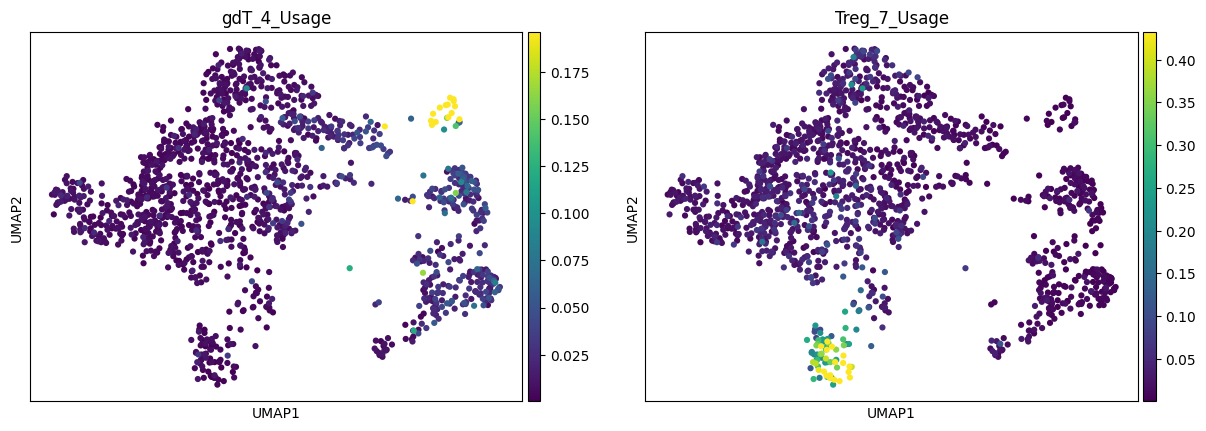

In [23]:
sc.pl.umap(query_adata, color=['gdT_4_Usage', 'Treg_7_Usage'], vmax='p99')